In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm # tqdm is a package that lets you make progress bars to see how a loop is going
import os 
import glob # this package lets you search for filenames
import pandas as pd # pandas is a popular library in industry for manipulating large data tables
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
# subsequent lines default plot settings
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(8.0,6.0)   
mpl.rcParams['font.size']=16              
mpl.rcParams['savefig.dpi']= 300             

In [2]:
#Monte Carlo 
def monte_carlo(xdata, xuncs, ydata, yuncs, iterations):

    # initialise arrays to store our data in
    grads = np.zeros(iterations)
    yints = np.zeros(iterations)
    x_rand = np.zeros(len(xdata))
    y_rand = np.zeros(len(xdata))
    #print(x_rand)
    
    # if our uncertainty is a scalar, make it an array with N times that value (N being the length of our data array)
    if np.size(xuncs) == 1:
        xuncs = np.ones(len(xdata)) * xuncs
    if np.size(yuncs) == 1:
        yuncs = np.ones(len(ydata)) * yuncs
    
    # now to perform n=iterations random samples of our data distributions
    for i in range(iterations):
        for j in range(len(xdata)):
            # generate a random normal variable for each of our XY data points
            x_rand[j] = np.random.normal(xdata[j], xuncs[j])
            y_rand[j] = np.random.normal(ydata[j], yuncs[j])
            
            
        # now fit a line to our random data. A 1-dimensional polynomial is just a straight line!
        grads[i], yints[i] = np.polyfit(x_rand, y_rand, 1)
        
    
    # now get the statistics of our *iterations* number of trendline parameters
    meangrad = np.mean(grads[:i])
    SDgrad = np.std(grads[:i])
    meanyint = np.mean(yints[:i])
    SDyint = np.std(yints[:i])
    return np.array([meangrad, SDgrad, meanyint, SDyint])

In [3]:
ddir_stars = 'C:/Users/emily/Documents/University/ThirdYear/FebuarySem/Astronomy/CosmicDistanceLadder/universe_8' # point this to where you unzip your data!

ddir = ddir_stars + '/Variable_Star_Data/'

fnames = glob.glob(ddir+'*.csv')

freqs = np.linspace(1/100,0.45,10000) # choose your grid so that it doesn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 
names = []

for fname in tqdm(fnames): # tqdm is a package that gives you a progress bar - neat! 
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables
    dflux=0.15*flux 

    LS = LombScargle(time,flux, dflux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    
    periods.append(1/bestfreq) # add each period to the list
    names.append(os.path.basename(fname).strip('.csv')) # os.path.basename gets rid of directories and gives you the filename; then we strip '.csv'

periods = np.array(periods) # turn it from a list to an array
names = np.array(names) # turn it from a list to an array

variables = pd.DataFrame({'Name':names,
              'Period':periods}) # turn two arrays into a dataframe

100%|██████████| 3360/3360 [00:39<00:00, 85.70it/s]


In [4]:
allStars=pd.read_csv(ddir_stars+'/AllStars.csv', index_col="Name")

closeStars=allStars.query('Parallax > 0.01')  # 10 mas parallax cut
print(len(closeStars), "Stars with good parallax") # check how many stars there are total with good parallax

800 Stars with good parallax


In [5]:
closeVariables=pd.merge(closeStars, variables, on='Name')
# merge these two arrays according to the keyword 'name'

print('Of which',len(closeVariables),'variables')


Of which 37 variables


Text(0, 0.5, 'Absolute Magnitude')

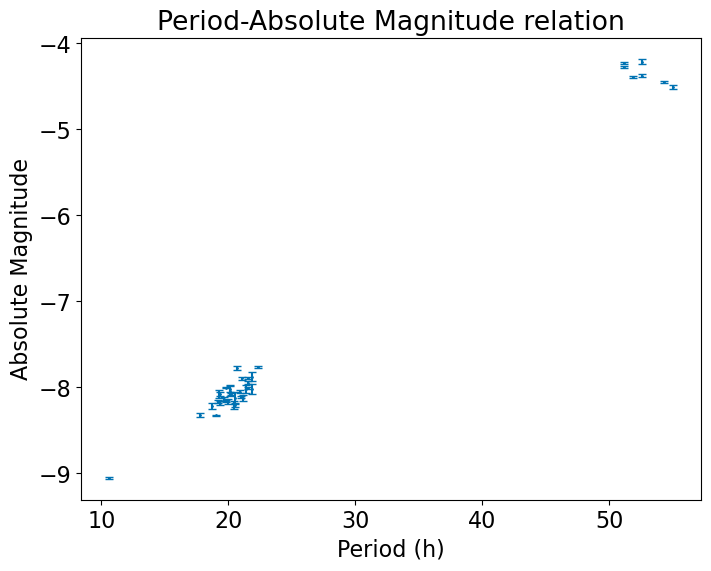

In [6]:
closeVariables['dGreenF']=0.01*closeVariables.GreenF
GreenF = closeVariables['GreenF'].to_numpy()
dGreenF = closeVariables['dGreenF'].to_numpy()

v0, v1, v2 = np.log10(closeVariables['BlueF']), np.log10(closeVariables['GreenF']), np.log10(closeVariables['RedF']) 
dv1=dGreenF/(GreenF*np.log(10))

variable_colour = v2-v0

luminosity = v1 + 2*np.log10(1./closeVariables.Parallax)
dparallax=0.001

a=1./closeVariables.Parallax
da=(dparallax/closeVariables.Parallax)*a

db=da/(a*np.log(10))
db=2*db

dlum=np.sqrt(db**2+dv1**2)
dp=0

closeVariables['Luminosity']=luminosity
closeVariables['dLum']=dlum

fig=plt.figure()
plt.errorbar(closeVariables.Period,closeVariables.Luminosity, dlum, dp, fmt='o', markersize=1, capsize=3)
plt.title("Period-Absolute Magnitude relation")
plt.xlabel('Period (h)')
plt.ylabel('Absolute Magnitude')


In [7]:

variableslong=closeVariables.query('Period > 45')
#variableslong=variableslong.reset_index()

variablesshort=closeVariables.query('Period > 15 and Period < 25')
#variablesshort=variablesshort.reset_index()


Long Gradient: -0.059585717109344905 +/- 0.0050442659191902665 Long Intercept: -1.2096976897324379 +/- 0.2644474223669197


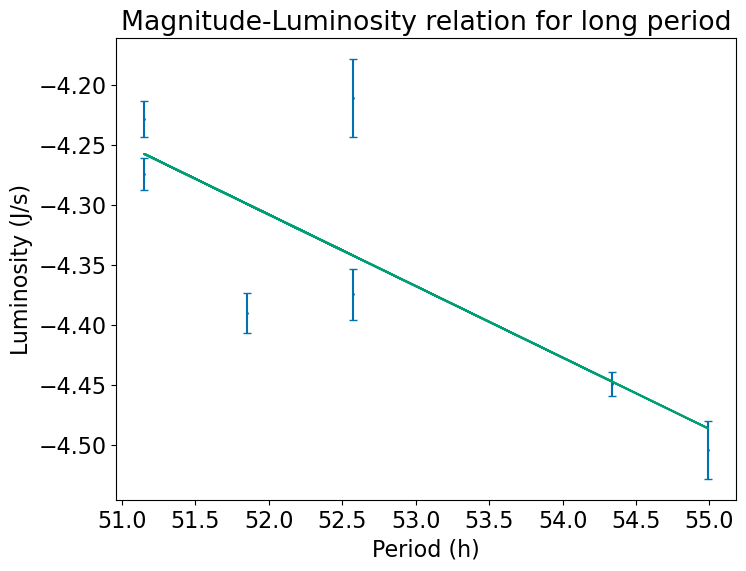

In [8]:

periodLongList=np.array(variableslong.Period)
LumLongList=np.array(variableslong.Luminosity)
dLumLongList=np.array(variableslong.dLum)

long=monte_carlo(periodLongList, dp, LumLongList, dLumLongList, 5000)

fig=plt.figure()
plt.errorbar(periodLongList,LumLongList, dLumLongList, dp, fmt='o', markersize=1, capsize=3)
plt.plot(variableslong.Period,(long[0]*variableslong.Period)+long[2])
plt.title("Magnitude-Period relation for long period")
plt.xlabel('Period (h)')
plt.ylabel('Absolute Magnitude')
print("Long Gradient:", long[0], "+/-", long[1], "Long Intercept:", long[2], "+/-", long[3])


Short Gradient: 0.09442548729332857 +/- 0.005291736433377463 Short Intercept: -9.991661491301398 +/- 0.10702838907705393


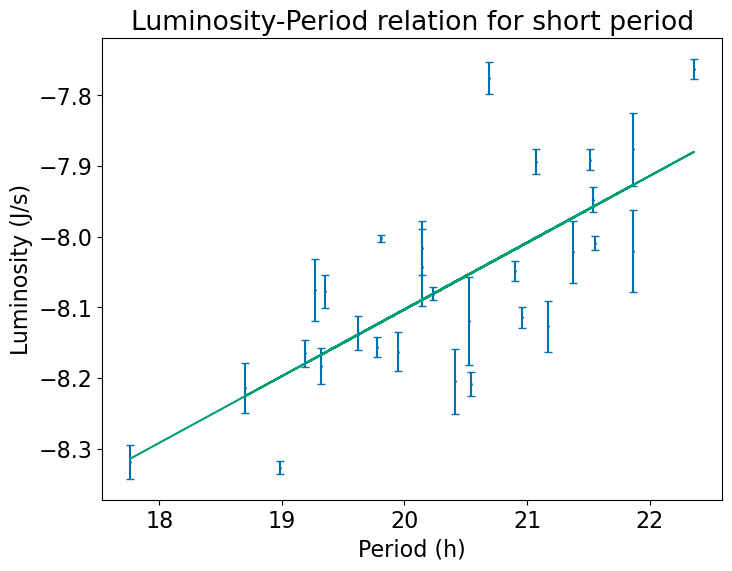

In [9]:

periodShortList=np.array(variablesshort.Period)
LumShortList=np.array(variablesshort.Luminosity)
dLumShortList=np.array(variablesshort.dLum)

short=monte_carlo(periodShortList, dp, LumShortList, dLumShortList, 5000)

fig=plt.figure()
plt.errorbar(periodShortList,LumShortList, dLumShortList, dp, fmt='o', markersize=1, capsize=3)
plt.plot(variablesshort.Period,(short[0]*variablesshort.Period)+short[2])
plt.title("Magnitude-Period relation for short period")
plt.xlabel('Period (h)')
plt.ylabel('Absolute Magnitude')
print("Short Gradient:", short[0], "+/-", short[1], "Short Intercept:", short[2], "+/-", short[3])

In [10]:
allVariables=pd.merge(allStars, variables, on='Name')
allVariableslong=allVariables.query('Period > 45')
allVariableslong['Luminosity']= (allVariableslong['Period']*long[0])+long[2]
allVariableslong['dLuminosity']= np.sqrt(((allVariableslong['Period']**2)*(long[1]**2))+(long[3]**2))
#allVariableslong['Distance']=np.power(10,(allVariableslong['Luminosity']-(np.log10(allVariableslong['GreenF'])))/2)

allVariables=pd.merge(allStars, variables, on='Name')
allVariablesshort=allVariables.query('Period > 15 and Period < 25')
allVariablesshort['Luminosity']= (allVariablesshort['Period']*short[0])+short[2]
allVariablesshort['dLuminosity']= np.sqrt(((allVariablesshort['Period']**2)*(short[1]**2))+(short[3]**2))
#allVariablesshort['Distance']=np.power(10,(allVariablesshort['Luminosity']-(np.log10(allVariablesshort['GreenF'])))/2)

finalVariables=pd.concat([allVariableslong,allVariablesshort])
finalVariables['dGreenF']=0.01*finalVariables.GreenF
finalVariables['Distance']=np.power(10,(finalVariables['Luminosity']-(np.log10(finalVariables['GreenF'])))/2)

g=np.log10(finalVariables.GreenF)
dg=finalVariables.dGreenF/(finalVariables.GreenF*np.log(10))

h=finalVariables.Luminosity-g
dh=np.sqrt(dg**2+finalVariables.dLuminosity**2)

h=h/2
dh=dh/2

i=np.power(10,h)
di=np.log(10)*i*dh

finalVariables['dDistance']=di

farVariables=finalVariables.query('Distance > 8000')

#plt.plot(allVariableslong.Distance, allVariableslong.Luminosity, color='red', marker='o', linestyle='none', markersize=1)
#plt.plot(allVariablesshort.Distance, allVariablesshort.Luminosity, color='green', marker='o', linestyle='none', markersize=1)
#plt.xlabel('Distance')
#plt.ylabel('Absolute Magnitude')
#plt.show()

#finalVariables.to_csv('Mag.csv', index=False)
farVariables.to_csv('Far.csv', index=False)